<a href="https://colab.research.google.com/github/ghubnerr/machine-learning/blob/main/GPT2_(%2BKV_Cache_%26_Kernel_Fusions).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attention Mechanisms and Transformers

For the notebook, the main papers we'll be basing our implementation on will be:

* [Attention is All You Need](https://arxiv.org/pdf/1706.03762) - Published by Google, researches the attention mechanism for machine translation specifically.
* [Improving Language Understanding by Generative Pre-Training](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf) - By OpenAI, the first use of decoder-only LLMs starting GPT-1.
* [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) - The second paper by OpenAI in the GPT lineup, realesing GPT-2.

`Credits: Gabriel Lucchesi and David Ulloa`

In [4]:
!pip install datasets transformers -q;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.9/274.9 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.3/231.3 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.1/344.1 kB 22.3 MB/s eta 0:00:00


In [5]:
from typing import Optional, Tuple, Union, Dict, Any, List

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from flax.training.train_state import TrainState
import datasets
import flax
import flax.linen as nn
import optax
import jax.random as jr
import jax.lax as lax
import tensorflow as tf
import tensorflow_datasets as tfds
import transformers

### Our Tokenizer: [HF AutoTokenizer](https://huggingface.co/docs/transformers/v4.49.0/en/model_doc/auto#transformers.AutoTokenizer)

In [ ]:
from transformers import AutoTokenizer

# The tokenizer we use must be the same as our model for compatability reasons
tokenizer = AutoTokenizer.from_pretrained("gpt2")

tokenizer.pad_token = tokenizer.eos_token

In [ ]:
tokenizer.encode("Hello, my dog is cute")

[15496, 11, 616, 3290, 318, 13779]

## Our Dataset

In [ ]:
from tqdm import tqdm,trange

In [ ]:
from datasets import load_dataset
import tempfile
import pickle
from pathlib import Path


SCRATCH_PATH = Path("")  # Enter path here
DATASET_PATH = SCRATCH_PATH / "openwebtext.pkl"

if not SCRATCH_PATH.exists():
    raise NotImplementedError()

# Loading dataset or downloading it if doesn't exist
if not DATASET_PATH.exists():
    dataset = load_dataset("openwebtext", split="train[:10%]", cache_dir=Path(SCRATCH_PATH / "hf_cache"))

    def tokenize_function(examples):
        return {
            "input_ids": tokenizer(
                examples["text"], truncation=True, padding="max_length", max_length=1024
            )["input_ids"]
        }

    dataset = dataset.map(tokenize_function, batched=True)
    dataset = dataset.shuffle(seed=42)

    with open(DATASET_PATH, "wb") as f:
        pickle.dump(dataset, f)

with open(DATASET_PATH, "rb") as f:
    dataset = pickle.load(f)

In [ ]:
# Dataset Helper Functions
def batch_dataset(dataset, batch_size):
    batch = {"input_ids": []}
    for example in dataset:
        batch["input_ids"].append(example["input_ids"])
        if len(batch["input_ids"]) == batch_size:
            yield {k: jnp.array(v, dtype=jnp.int32) for k, v in batch.items()}
            batch = {"input_ids": []}

def shard_batch(batch):
    batch_size = batch["input_ids"].shape[0]
    per_device_batch = batch_size // jax.device_count()
    return jax.tree.map(lambda x: x.reshape((jax.device_count(), per_device_batch, -1)), batch)

## Breaking Attention Into Blocks

<div align="center">
  <img src="https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1.png"
       alt="Image" width="300" height="400" />
</div>

The attention mechanism lies within the transformer architecture, meaning the picture below is the general architecture to how we will build our GPT-2 model. At first, the image looks like a lot - so we'll break down each part step-by-step.

* **Positional Embeddings:** Values appended to the embeddings, which are important because the attention architecture doesn't involve position to begin with. You can see how these embeddings looked, plotted, [here](https://en.wikipedia.org/wiki/Softmax_function).
* **Multi-Head Attention:** Where the attention mechanism takes place, using the KQV formula below:

$$
Attention(K, Q, V) = softmax(\frac{QK^T}{\sqrt{d}})V
$$

* Aside from simply applying this equation, our model will split the input embeddings into seperate "attention" heads. The splitting allows for attention in each head to focus on different features of our input.

<div align="center">
    <img src="https://jalammar.github.io/images/t/transformer_multi-headed_self-attention-recap.png" alt="Image" width="450" height="300" />
</div>

* **Add & Norm:** After the attention process, we always have a "Add & Norm" block. In code it looks fairly simple, involving [layer normalization](https://arxiv.org/abs/1607.06450) and a [residual connection](https://en.wikipedia.org/wiki/Residual_neural_network): `Output = LayerNorm(X + Attention(X))`
* **Feed Foward:** Throughout the transformer, these blocks are MLPs which are simply a sequence of dense layers. Most of the weights (and knowledge learned) in the model are located here.
* **Softmax & Linear:** Finally, at the end of our model, we apply a single linear layer and [softmax](https://en.wikipedia.org/wiki/Softmax_function) function to create a probability distribution over what word to predict next.

<div align="center">
  <img src="https://jalammar.github.io/images/t/transformer_decoder_output_softmax.png"
       alt="Image" width="400" height="300" />
</div>

### GPT-2's Configurations

Here are some configuration variables that our GPT model will use. Notice, we're using a [dataclass](https://docs.python.org/3/library/dataclasses.html) - which makes defining classes more concise.

In [6]:
from dataclasses import dataclass

In [13]:
@dataclass
class GPT2Config:
    vocab_size: int = 50257
    max_position_embeddings: int = 1024
    n_embd: int = 768
    n_layer: int = 12
    n_head: int = 12
    n_inner: int = 3072
    layer_norm_epsilon: float = 1e-5
    dropout_rate: float = 0.1
    max_sequence_length: int = 1024
    attn_dropout_rate: float = 0.1
    initializer_range: float = 0.02

### Multi-Head Self-Attention

As previously mentioned, the multi-head self attention applies the attention mechanism while splitting into seperate heads. The process is as simple as apportioning different parts of our input to different attention heads in set intervals, defined by `batch_size / n_head`.

<div align="center">
    <img src="https://jalammar.github.io/images/t/transformer_attention_heads_z.png" alt="Image" width="600" height="300" />
</div>

<div align="center">
    <img src="https://raw.githubusercontent.com/chloeli-15/ARENA_img/main/img/transformer-attn-new-v2.png" alt="Image" width="600" height="300" />
</div>

In [ ]:
class MHSelfAttention(nn.Module):
    config: GPT2Config

    @nn.compact
    def __call__(self, hidden_states, deterministic: bool = True):
        """
        hidden_states: [batch_size, sequence_length, n_embd]
        """
        cfg = self.config
        batch_size, seq_length, hidden_dim = hidden_states.shape
        assert hidden_dim == cfg.n_embd

        qkv = nn.Dense(
            cfg.n_embd * 3,
            use_bias=True,
            kernel_init=nn.initializers.normal(cfg.initializer_range),
            bias_init=nn.initializers.zeros
        )(hidden_states)

        qkv = qkv.reshape(batch_size, seq_length, 3, cfg.n_head, cfg.n_embd // cfg.n_head)
        q, k, v = jnp.split(qkv, 3, axis=2)
        q = q.squeeze(axis=2)  # [batch_size, seq_length, n_head, head_dim]
        k = k.squeeze(axis=2)
        v = v.squeeze(axis=2)

        # Transpose for (batch, head, seq, head_dim)
        q = q.transpose((0, 2, 1, 3))
        k = k.transpose((0, 2, 1, 3))
        v = v.transpose((0, 2, 1, 3))

        causal_mask = jnp.tril(jnp.ones((seq_length, seq_length)))
        causal_mask = causal_mask.reshape(1, 1, seq_length, seq_length)

        # Scaled dot-product attention
        dk = jnp.sqrt(k.shape[-1]).astype(q.dtype)
        attn_weights = jnp.matmul(q, k.transpose((0, 1, 3, 2))) / dk

        # Apply the mask
        attn_weights = jnp.where(causal_mask == 0, -1e10, attn_weights)

        attn_probs = nn.softmax(attn_weights, axis=-1)
        attn_probs = nn.Dropout(rate=cfg.attn_dropout_rate)(attn_probs, deterministic=deterministic)

        # Multiply by value matrix
        attn_output = jnp.matmul(attn_probs, v)

         # Revert transpose
        attn_output = attn_output.transpose((0, 2, 1, 3))

        # Combine heads
        attn_output = attn_output.reshape(batch_size, seq_length, cfg.n_embd)

        # Final linear projection
        out = nn.Dense(
            cfg.n_embd,
            use_bias=True,
            kernel_init=nn.initializers.normal(cfg.initializer_range),
            bias_init=nn.initializers.zeros
        )(attn_output)

        return out

### The MLP Block

The MLP block, otherwise known as a feed forward network. As previously mentioned, the MLP holds two-thirds of the LLM's weights and is also where "information" is stored.

Let's say the words "Micheal Jordan" is inputted, attention would create the relationship that Michael before Jordan is a significant relationship, but the MLP learns who he is and what achievements he has.

<div align="center">
    <img src="https://raw.githubusercontent.com/chloeli-15/ARENA_img/main/img/transformer-mlp-new-2.png" alt="Image" width="550" height="400" />
</div>

In [ ]:
class MLP(nn.Module):
    config: GPT2Config

    @nn.compact
    def __call__(self, hidden_states, deterministic: bool = True):
        cfg = self.config

        hidden = nn.Dense(
            cfg.n_inner,
            kernel_init=nn.initializers.normal(cfg.initializer_range),
            bias_init=nn.initializers.zeros
        )(hidden_states)
        hidden = nn.gelu(hidden)

        hidden = nn.Dense(
            cfg.n_embd,
            kernel_init=nn.initializers.normal(cfg.initializer_range),
            bias_init=nn.initializers.zeros
        )(hidden)

        hidden = nn.Dropout(rate=cfg.dropout_rate)(hidden, deterministic=deterministic)
        return hidden

### Transformer Block

Finally, we get to the transformer block, which we'll create a list of, for our GPT-2 model. In general, this same transformer block that we'll create can be used to make up different sizes of GPT-2.

<div align="center">
    <img src="https://raw.githubusercontent.com/chloeli-15/ARENA_img/main/img/transformer-block2.png" alt="Image" width="600" height="400" />
</div>


In [ ]:
class TransformerBlock(nn.Module):
    config: GPT2Config

    @nn.compact
    def __call__(self, hidden_states, deterministic: bool = True):
        cfg = self.config

        attn_ln = nn.LayerNorm(epsilon=cfg.layer_norm_epsilon)(hidden_states)
        attn_out = MHSelfAttention(cfg)(attn_ln, deterministic=deterministic)
        attn_out = nn.Dropout(rate=cfg.dropout_rate)(attn_out, deterministic=deterministic)

        x = hidden_states + attn_out

        mlp_ln = nn.LayerNorm(epsilon=cfg.layer_norm_epsilon)(x)
        mlp_out = MLP(cfg)(mlp_ln, deterministic=deterministic)

        # Residual
        x = x + mlp_out

        return x

## Putting GPT-2 Together

Finally, let's put it all together...

![image](https://www.researchgate.net/publication/373352176/figure/fig1/AS:11431281202501967@1698856108167/GPT-2-model-architecture-The-GPT-2-model-contains-N-Transformer-decoder-blocks-as-shown.ppm)

In [ ]:
class GPT2(nn.Module):
    config: GPT2Config

    def setup(self):
        # Embedding shared by input and output
        self.wte = nn.Embed(
            num_embeddings=self.config.vocab_size,
            features=self.config.n_embd,
            embedding_init=nn.initializers.normal(self.config.initializer_range)
        )
        self.wpe = self.param(
            "wpe",
            nn.initializers.normal(self.config.initializer_range),
            (self.config.max_position_embeddings, self.config.n_embd)
        )
        self.blocks = [TransformerBlock(self.config) for _ in range(self.config.n_layer)]
        self.ln_f = nn.LayerNorm(epsilon=self.config.layer_norm_epsilon)
        self.dropout = nn.Dropout(rate=self.config.dropout_rate)

    def __call__(self, input_ids, deterministic=True):
        # Input embedding
        position_ids = jnp.arange(input_ids.shape[1])[None, :]
        token_embeds = self.wte(input_ids)
        position_embeds = self.wpe[position_ids, :]
        hidden_states = token_embeds + position_embeds
        hidden_states = self.dropout(hidden_states, deterministic=deterministic)

        # Transformer blocks
        for block in self.blocks:
            hidden_states = block(hidden_states, deterministic=deterministic)

        # Final layer norm
        hidden_states = self.ln_f(hidden_states)

        # Output logits by tying embeddings
        # We transpose the embedding matrix from [vocab_size, n_embd] to [n_embd, vocab_size]
        wte_tied = self.wte.embedding.T  # shape: [n_embd, vocab_size]
        logits = jnp.einsum("bld,dk->blk", hidden_states, wte_tied)
        return logits

## Training GPT-2

In [ ]:
config = GPT2Config()

model = GPT2(config)

rng = jax.random.PRNGKey(0)
dummy_input = jnp.zeros((1, 1024), dtype=jnp.int32)
params = model.init(rng, dummy_input)['params']

optimizer = optax.adamw(learning_rate=5e-5)
state = TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

param_count = sum(p.size for p in jax.tree_util.tree_leaves(params))
print(param_count, f"({param_count / 1e6:.2f}M)")

124439808 (124.44M)


In [ ]:
import flax.serialization as flax_serialization

@dataclass
class TrainingParams:
    num_epochs = 1
    batch_size = 8
    seq_length = 1024

# state = jax.device_put_replicated(state, jax.devices())

CHECKPOINT_DIR = SCRATCH_PATH / "checkpoints"

if not CHECKPOINT_DIR.exists():
    raise NotImplementedError()

def save_model(state, filename):
    state_dict = flax.serialization.to_state_dict(state)
    with open(CHECKPOINT_DIR / filename, "wb") as f:
        f.write(flax_serialization.msgpack_serialize(state_dict))

def load_model(state, filename):
    with open(CHECKPOINT_DIR/ filename, "rb") as f:
        loaded_state_dict = flax_serialization.msgpack_restore(f.read())
    return flax.serialization.from_state_dict(state, loaded_state_dict)

In [ ]:
@jax.pmap
def train_step(state, batch):
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, batch['input_ids'])
        loss = jnp.mean(optax.softmax_cross_entropy_with_integer_labels(
            logits[:, :-1, :], batch['input_ids'][:, 1:]
        ))
        return loss

    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss

In [ ]:
training = TrainingParams()

for epoch in range(1, training.num_epochs + 1):
    step = 0
    progress_bar = tqdm(desc=f"Epoch {epoch}", unit="batch")

    for batch in batch_dataset(dataset, batch_size=training.batch_size):
        batch = shard_batch(batch)  # => (8, 1, 1024)
        state, loss = train_step(state, batch)

        if step % 100 == 0:
            progress_bar.set_postfix(loss=loss.mean().item())
        step += 1
        progress_bar.update(1)

        save_model(state, f"checkpoint_epoch_{epoch}.msgpack")

    print(f"Epoch {epoch} completed. Loss: {loss.mean()}")
    progress_bar.close()

In [ ]:
def print_param_shapes(params, prefix=""):
    if isinstance(params, dict):
        for name, param in params.items():
            print_param_shapes(param, prefix + name + ".")
    else:
        print(f"{prefix[:-1]}: shape {params.shape}")

loaded_state = load_model(state, f"checkpoint_epoch_5.msgpack")
print_param_shapes(loaded_state.params)

wpe: shape (8, 1024, 768)
wte.embedding: shape (8, 50257, 768)
blocks_0.LayerNorm_0.scale: shape (8, 768)
blocks_0.LayerNorm_0.bias: shape (8, 768)
blocks_0.MHSelfAttention_0.Dense_0.kernel: shape (8, 768, 2304)
blocks_0.MHSelfAttention_0.Dense_0.bias: shape (8, 2304)
blocks_0.MHSelfAttention_0.Dense_1.kernel: shape (8, 768, 768)
blocks_0.MHSelfAttention_0.Dense_1.bias: shape (8, 768)
blocks_0.LayerNorm_1.scale: shape (8, 768)
blocks_0.LayerNorm_1.bias: shape (8, 768)
blocks_0.MLP_0.Dense_0.kernel: shape (8, 768, 3072)
blocks_0.MLP_0.Dense_0.bias: shape (8, 3072)
blocks_0.MLP_0.Dense_1.kernel: shape (8, 3072, 768)
blocks_0.MLP_0.Dense_1.bias: shape (8, 768)
blocks_1.LayerNorm_0.scale: shape (8, 768)
blocks_1.LayerNorm_0.bias: shape (8, 768)
blocks_1.MHSelfAttention_0.Dense_0.kernel: shape (8, 768, 2304)
blocks_1.MHSelfAttention_0.Dense_0.bias: shape (8, 2304)
blocks_1.MHSelfAttention_0.Dense_1.kernel: shape (8, 768, 768)
blocks_1.MHSelfAttention_0.Dense_1.bias: shape (8, 768)
blocks_1.

In [ ]:
unsharded_params = jax.tree.map(lambda x: x[0] if x.shape[0] == 8 else x, loaded_state.params)

unsharded_state = TrainState.create(
    apply_fn=model.apply,
    params=unsharded_params,
    tx=optax.adamw(learning_rate=5e-5)
)

In [ ]:
print_param_shapes(unsharded_state.params)

blocks_0.LayerNorm_0.bias: shape (768,)
blocks_0.LayerNorm_0.scale: shape (768,)
blocks_0.LayerNorm_1.bias: shape (768,)
blocks_0.LayerNorm_1.scale: shape (768,)
blocks_0.MHSelfAttention_0.Dense_0.bias: shape (2304,)
blocks_0.MHSelfAttention_0.Dense_0.kernel: shape (768, 2304)
blocks_0.MHSelfAttention_0.Dense_1.bias: shape (768,)
blocks_0.MHSelfAttention_0.Dense_1.kernel: shape (768, 768)
blocks_0.MLP_0.Dense_0.bias: shape (3072,)
blocks_0.MLP_0.Dense_0.kernel: shape (768, 3072)
blocks_0.MLP_0.Dense_1.bias: shape (768,)
blocks_0.MLP_0.Dense_1.kernel: shape (3072, 768)
blocks_1.LayerNorm_0.bias: shape (768,)
blocks_1.LayerNorm_0.scale: shape (768,)
blocks_1.LayerNorm_1.bias: shape (768,)
blocks_1.LayerNorm_1.scale: shape (768,)
blocks_1.MHSelfAttention_0.Dense_0.bias: shape (2304,)
blocks_1.MHSelfAttention_0.Dense_0.kernel: shape (768, 2304)
blocks_1.MHSelfAttention_0.Dense_1.bias: shape (768,)
blocks_1.MHSelfAttention_0.Dense_1.kernel: shape (768, 768)
blocks_1.MLP_0.Dense_0.bias: shap

In [ ]:
@jax.jit
def infer(params, input_ids):
    logits = model.apply({'params': params}, input_ids, deterministic=True)
    return logits

input_text = (
    "Once upon a time,"
)

encoded_input = tokenizer.encode(input_text, return_tensors="np")
input_ids = jnp.array(encoded_input)        # shape: (1, seq_length)
input_ids = jax.device_put(input_ids)         # ensure it’s on the GPU

params_single = jax.device_put(unsharded_state.params)

num_tokens_to_generate = 10

generated_ids = input_ids

rng = jax.random.PRNGKey(0)

temperature = 0.7

for _ in range(num_tokens_to_generate):
    logits = infer(params_single, generated_ids)
    last_token_logits = logits[:, -1, :] / temperature

    rng, sub_rng = jax.random.split(rng)
    next_token_id = int(jax.random.categorical(sub_rng, last_token_logits[0]))

    next_token = jnp.array([[next_token_id]])
    generated_ids = jnp.concatenate([generated_ids, next_token], axis=1)


In [ ]:
generated_text = tokenizer.decode(generated_ids[0].tolist())
print(generated_text)

Once upon a time, when a man could go against the man to the


## Let's make this faster


### Implementing KV-Caching
<div align="center">
<img src="https://miro.medium.com/v2/resize:fit:1400/1*4RwWnUm8zaUJmME0RkkUBQ.png" />
</div>

The transparent rows are the only thing we actually want to compute :)





$$ \begin{aligned}
&x_K^i \leftarrow \text{Concat}\bigl(x_K^i,\; t^i \cdot W_K^i \bigr),\\[1mm]
&x_V^i \leftarrow \text{Concat}\bigl(x_V^i,\; t^i \cdot W_V^i \bigr),\\[1mm]
&t_Q^i = t^i \cdot W_Q^i,\\[1mm]
&t_{out}^i = \mathrm{softmax}\Bigl(\frac{t_Q^i \,(x_K^i)^\top}{\sqrt{h}}\Bigr)\; x_V^i \; W_O^i \;+\; t^i,\\[1mm]
&t^{i+1} = \sigma\bigl(t_{out}^i \cdot W_1\bigr)\, W_2 \;+\; t_{out}^i.
\end{aligned}$$

#### **Key Operations in KV Caching**
- **During the first step (prompt processing):** Compute and store the full **K** and **V** tensors.
- **For subsequent tokens:**
  - Retrieve cached **K** and **V** tensors.
  - Concatenate the new token's **K** and **V** to the cache.
  - Compute attention only on the updated sequence.

Now the computation scale goes to $O(T)$ instead of $O(T^2)$.

In [14]:
class MHSelfAttention(nn.Module):
    config: GPT2Config

    @nn.compact
    def __call__(
        self,
        hidden_states: jnp.ndarray,
        deterministic: bool = True,
        cached_key: Optional[jnp.ndarray] = None,
        cached_value: Optional[jnp.ndarray] = None,
    ) -> Tuple[jnp.ndarray, Tuple[jnp.ndarray, jnp.ndarray]]:
        """
        hidden_states: [batch, new_seq_len, n_embd]
        cached_key:   [batch, n_heads, prev_seq_len, head_dim] or None
        cached_value: [batch, n_heads, prev_seq_len, head_dim] or None
        """
        cfg = self.config
        batch_size, new_seq_len, hidden_dim = hidden_states.shape
        head_dim = hidden_dim // cfg.n_head

        qkv = nn.Dense(
            cfg.n_embd * 3,
            use_bias=True,
            kernel_init=nn.initializers.normal(cfg.initializer_range),
            bias_init=nn.initializers.zeros,
        )(hidden_states)

        qkv = qkv.reshape(batch_size, new_seq_len, 3, cfg.n_head, head_dim)
        q, k, v = jnp.split(qkv, 3, axis=2)
        q = q.squeeze(axis=2)  # [batch, new_seq_len, n_head, head_dim]
        k = k.squeeze(axis=2)
        v = v.squeeze(axis=2)

        q = q.transpose((0, 2, 1, 3))
        k = k.transpose((0, 2, 1, 3))
        v = v.transpose((0, 2, 1, 3))

        # Concatenate along the sequence dimension
        if cached_key is not None and cached_value is not None:
            k = jnp.concatenate([cached_key, k], axis=2)  # seq dimension = axis=2
            v = jnp.concatenate([cached_value, v], axis=2)

        seq_len_q = q.shape[2]   # new_seq_len
        seq_len_k = k.shape[2]   # total length so far (prev + new)

        base_mask = jnp.tril(jnp.ones((seq_len_k, seq_len_k)))
        causal_mask = base_mask[-seq_len_q:, :]
        causal_mask = causal_mask[None, None, :, :]

        dk = jnp.sqrt(head_dim).astype(q.dtype)
        attn_logits = jnp.matmul(q, k.transpose((0, 1, 3, 2))) / dk
        attn_logits = jnp.where(causal_mask == 0, -1e10, attn_logits)

        attn_weights = nn.softmax(attn_logits, axis=-1)
        attn_weights = nn.Dropout(rate=cfg.attn_dropout_rate)(attn_weights, deterministic=deterministic)

        attn_output = jnp.matmul(attn_weights, v)
        attn_output = attn_output.transpose((0, 2, 1, 3))
        attn_output = attn_output.reshape(batch_size, new_seq_len, cfg.n_embd)

        out = nn.Dense(
            cfg.n_embd,
            use_bias=True,
            kernel_init=nn.initializers.normal(cfg.initializer_range),
            bias_init=nn.initializers.zeros,
        )(attn_output)

        return out, (k, v)

In [ ]:
class TransformerBlock(nn.Module):
    config: GPT2Config

    @nn.compact
    def __call__(
        self,
        hidden_states: jnp.ndarray,
        deterministic: bool = True,
        cached_key: Optional[jnp.ndarray] = None,
        cached_value: Optional[jnp.ndarray] = None
    ) -> Tuple[jnp.ndarray, Tuple[jnp.ndarray, jnp.ndarray]]:
        cfg = self.config

        ln_attn = nn.LayerNorm(epsilon=cfg.layer_norm_epsilon)(hidden_states)
        attn_out, (updated_k, updated_v) = MHSelfAttention(cfg)(
            ln_attn, deterministic=deterministic,
            cached_key=cached_key, cached_value=cached_value
        )
        attn_out = nn.Dropout(rate=cfg.dropout_rate)(attn_out, deterministic=deterministic)
        x = hidden_states + attn_out

        ln_mlp = nn.LayerNorm(epsilon=cfg.layer_norm_epsilon)(x)
        mlp_out = MLP(cfg)(ln_mlp, deterministic=deterministic)
        x = x + mlp_out

        return x, (updated_k, updated_v)

In [ ]:
class GPT2(nn.Module):
    config: GPT2Config

    def setup(self):
        cfg = self.config
        self.wte = nn.Embed(
            num_embeddings=cfg.vocab_size,
            features=cfg.n_embd,
            embedding_init=nn.initializers.normal(cfg.initializer_range),
        )
        self.wpe = self.param(
            "wpe",
            nn.initializers.normal(cfg.initializer_range),
            (cfg.max_position_embeddings, cfg.n_embd),
        )
        self.blocks = [TransformerBlock(cfg) for _ in range(cfg.n_layer)]
        self.ln_f = nn.LayerNorm(epsilon=cfg.layer_norm_epsilon)
        self.dropout = nn.Dropout(rate=cfg.dropout_rate)

    def __call__(
        self,
        input_ids: jnp.ndarray,
        deterministic: bool = True,
        past_key_values: Optional[List[Tuple[jnp.ndarray, jnp.ndarray]]] = None,
        use_cache: bool = False,
    ) -> Union[jnp.ndarray, Tuple[jnp.ndarray, List[Tuple[jnp.ndarray, jnp.ndarray]]]]:
        """
        input_ids: [batch, seq_len] (can be the full prompt or just the new token).
        past_key_values: list of (k, v) tuples, each shape [batch, n_heads, prev_seq_len, head_dim]
        use_cache: whether to return updated k/v caches
        """

        cfg = self.config
        batch_size, seq_len = input_ids.shape

        # Determine offset for position IDs if we have a cache:
        if past_key_values is not None and past_key_values[0][0] is not None:
            offset = past_key_values[0][0].shape[2]  # 'prev_seq_len' from shape [b, n_heads, prev_seq_len, head_dim]
        else:
            offset = 0

        position_ids = jnp.arange(offset, offset + seq_len, dtype=jnp.int32)[None, :]

        token_embeds = self.wte(input_ids)  # [batch, seq_len, n_embd]
        position_embeds = jnp.take(self.wpe, position_ids, axis=0)  # also [batch, seq_len, n_embd]
        hidden_states = token_embeds + position_embeds
        hidden_states = self.dropout(hidden_states, deterministic=deterministic)

        if past_key_values is None:
            past_key_values = [(None, None)] * len(self.blocks)

        new_key_values = []
        for block, (cached_k, cached_v) in zip(self.blocks, past_key_values):
            hidden_states, (updated_k, updated_v) = block(
                hidden_states,
                deterministic=deterministic,
                cached_key=cached_k,
                cached_value=cached_v,
            )
            new_key_values.append((updated_k, updated_v))

        hidden_states = self.ln_f(hidden_states)

        wte_tied = self.wte.embedding.T  # shape [n_embd, vocab_size]
        logits = jnp.einsum("bld,dk->blk", hidden_states, wte_tied)

        if use_cache:
            return logits, new_key_values
        else:
            return logits


### Dummy Input and Shape Check (Unsharded)

In [ ]:
dummy_input = jnp.zeros((1, 1024), dtype=jnp.int32)

config = GPT2Config()
model = GPT2(config)

rng = jax.random.PRNGKey(0)
params = model.init(rng, dummy_input)['params']
state = TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

logits = model.apply({'params': params}, dummy_input, deterministic=True, use_cache=False)
print("Logits shape (no cache):", logits.shape)

logits, new_key_values = model.apply(
    {'params': params},
    dummy_input,
    deterministic=True,
    use_cache=True
)
print("Logits shape (with cache):", logits.shape)

for i, (k, v) in enumerate(new_key_values):
    print(f"Layer {i}: k shape: {k.shape}, v shape: {v.shape}")

Logits shape (no cache): (1, 1024, 50257)
Logits shape (with cache): (1, 1024, 50257)
Layer 0: k shape: (1, 12, 1024, 64), v shape: (1, 12, 1024, 64)
Layer 1: k shape: (1, 12, 1024, 64), v shape: (1, 12, 1024, 64)
Layer 2: k shape: (1, 12, 1024, 64), v shape: (1, 12, 1024, 64)
Layer 3: k shape: (1, 12, 1024, 64), v shape: (1, 12, 1024, 64)
Layer 4: k shape: (1, 12, 1024, 64), v shape: (1, 12, 1024, 64)
Layer 5: k shape: (1, 12, 1024, 64), v shape: (1, 12, 1024, 64)
Layer 6: k shape: (1, 12, 1024, 64), v shape: (1, 12, 1024, 64)
Layer 7: k shape: (1, 12, 1024, 64), v shape: (1, 12, 1024, 64)
Layer 8: k shape: (1, 12, 1024, 64), v shape: (1, 12, 1024, 64)
Layer 9: k shape: (1, 12, 1024, 64), v shape: (1, 12, 1024, 64)
Layer 10: k shape: (1, 12, 1024, 64), v shape: (1, 12, 1024, 64)
Layer 11: k shape: (1, 12, 1024, 64), v shape: (1, 12, 1024, 64)


### Loading a trained model and applying KV Cache

In [ ]:
loaded_state = load_model(state, f"checkpoint_epoch_100_1.msgpack")
unsharded_params = jax.tree.map(lambda x: x[0] if x.shape[0] == 8 else x, loaded_state.params)

unsharded_state = TrainState.create(
    apply_fn=model.apply,
    params=unsharded_params,
    tx=optax.adamw(learning_rate=5e-5)
)

In [ ]:
logits, new_key_values = model.apply(
    {'params': unsharded_state.params},
    dummy_input,
    deterministic=True,
    use_cache=True
)
print("Logits shape (with cache):", logits.shape)
for i, (k, v) in enumerate(new_key_values):
    print(f"Layer {i}: k shape: {k.shape}, v shape: {v.shape}")

Logits shape (with cache): (1, 1024, 50257)
Layer 0: k shape: (1, 12, 1024, 64), v shape: (1, 12, 1024, 64)
Layer 1: k shape: (1, 12, 1024, 64), v shape: (1, 12, 1024, 64)
Layer 2: k shape: (1, 12, 1024, 64), v shape: (1, 12, 1024, 64)
Layer 3: k shape: (1, 12, 1024, 64), v shape: (1, 12, 1024, 64)
Layer 4: k shape: (1, 12, 1024, 64), v shape: (1, 12, 1024, 64)
Layer 5: k shape: (1, 12, 1024, 64), v shape: (1, 12, 1024, 64)
Layer 6: k shape: (1, 12, 1024, 64), v shape: (1, 12, 1024, 64)
Layer 7: k shape: (1, 12, 1024, 64), v shape: (1, 12, 1024, 64)
Layer 8: k shape: (1, 12, 1024, 64), v shape: (1, 12, 1024, 64)
Layer 9: k shape: (1, 12, 1024, 64), v shape: (1, 12, 1024, 64)
Layer 10: k shape: (1, 12, 1024, 64), v shape: (1, 12, 1024, 64)
Layer 11: k shape: (1, 12, 1024, 64), v shape: (1, 12, 1024, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 960/960 [29:36<00:00,  1.85s/it]


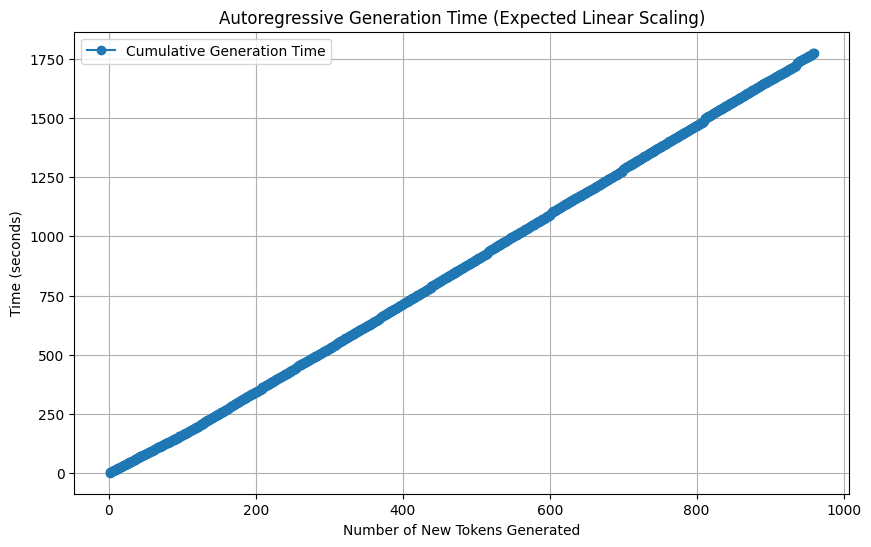

Generated text:
Once upon a time, I got asked how many legs a dog had. And I said: ative is a huge amount of people being thought to make anyone think that would be a high school in the world.

The whole family known as "ScAttling," said one of the largest people in the world are considering a large number of people to the world's largest and 40,000 people and four of them to the country.

There are a lot of people who live here on music or even the country and there are so many people who are looking for a dog who actually really loved and have their children looking for it, but one of them is so as many people want to buy.

"We are both a lot of people who are looking to find out and look at them," said one of the biggest causes of the world.

"We stand in the park and we are going to start seeing the problems that we are going to get jobs and start driving that day and to make sure that what that's going to happen."

The idea is that keeping the people who come from the streets and 

In [ ]:
from tqdm import trange
import time
import matplotlib.pyplot as plt

@jax.jit
def infer(params, input_ids, past_key_values=None):
    logits, past_key_values = model.apply(
        {'params': params},
        input_ids,
        deterministic=True,
        use_cache=True,
        past_key_values=past_key_values
    )
    return logits, past_key_values

prompt_text = "Once upon a time, I got asked how many legs a dog had. And I said: "
prompt_ids = tokenizer.encode(prompt_text, add_special_tokens=False)
prompt_ids = jnp.array(prompt_ids, dtype=jnp.int32)[None, :]  # shape: (1, seq_length)

eos_token_id = tokenizer.eos_token_id
max_new_tokens = 960
generated_tokens = list(np.array(prompt_ids[0]))
times = []

past_key_values = None

rng = jax.random.PRNGKey(0)
temperature = 0.7

for i in trange(max_new_tokens):
    start_time = time.time()

    input_ids = prompt_ids[:, -1:]

    logits, past_key_values = infer(unsharded_params, input_ids, past_key_values)
    next_token_logits = logits[:, -1, :] / temperature

    rng, sub_rng = jax.random.split(rng)
    next_token_id = int(jax.random.categorical(sub_rng, next_token_logits[0]))

    generated_tokens.append(next_token_id)

    if next_token_id == eos_token_id:
        break

    next_input_ids = jnp.array([[next_token_id]], dtype=jnp.int32)
    prompt_ids = jnp.concatenate([prompt_ids, next_input_ids], axis=1)

    end_time = time.time()
    times.append(end_time - start_time)

cumulative_times = np.cumsum(times)
token_indices = np.arange(1, len(cumulative_times) + 1)

plt.figure(figsize=(10, 6))
plt.plot(token_indices, cumulative_times, marker='o', label='Cumulative Generation Time')
plt.xlabel("Number of New Tokens Generated")
plt.ylabel("Time (seconds)")
plt.title("Autoregressive Generation Time (Expected Linear Scaling)")
plt.legend()
plt.grid(True)
plt.show()

final_output_text = tokenizer.decode(generated_tokens)
print("Generated text:")
print(final_output_text)

# Kernel Optimizations


### Using Fused Attention Kernels for GPU - [Pallas kernel code](https://github.com/jax-ml/jax/blob/main/jax/experimental/pallas/ops/gpu/attention.py)

In [27]:
@dataclass
class FusedAttnGPT2Config:
    vocab_size: int = 50257
    max_position_embeddings: int = 8192
    n_embd: int = 2048
    n_layer: int = 24
    n_head: int = 32
    n_inner: int = 8192
    layer_norm_epsilon: float = 1e-5
    dropout_rate: float = 0.1
    max_sequence_length: int = 8192
    attn_dropout_rate: float = 0.1
    initializer_range: float = 0.02


In [28]:
from jax.experimental.pallas.ops.gpu import attention

class FusedMHSelfAttention(nn.Module):
    config: FusedAttnGPT2Config

    @nn.compact
    def __call__(self, hidden_states, deterministic=True, cached_key=None, cached_value=None):
        cfg = self.config
        batch_size, seq_len, hidden_dim = hidden_states.shape
        head_dim = hidden_dim // cfg.n_head

        qkv = nn.Dense(cfg.n_embd * 3, use_bias=True, name="qkv_proj")(hidden_states)
        qkv = qkv.reshape(batch_size, seq_len, 3, cfg.n_head, head_dim)
        q, k, v = jnp.split(qkv, 3, axis=2)
        q, k, v = [x.squeeze(2).transpose(0, 2, 1, 3) for x in (q, k, v)]

        if cached_key is not None and cached_value is not None:
            k = jnp.concatenate([cached_key, k], axis=2)
            v = jnp.concatenate([cached_value, v], axis=2)

        attn_output = attention.mha(
            q, k, v,
            segment_ids=None,
            sm_scale = 1 / (head_dim ** 0.5),
            causal=True,
            block_q=64,
            block_k=64
        )

        attn_output = attn_output.transpose(0, 2, 1, 3).reshape(batch_size, seq_len, hidden_dim)
        out = nn.Dense(cfg.n_embd, use_bias=True, name="out_proj")(attn_output)
        return out, (k, v)

#### Comparing with standard MHSA

In [11]:
import timeit

def benchmark_mha(attention_module, params, hidden_states):
    """Benchmarks the MHA module with JAX jit compilation."""
    mha_fn = jax.jit(lambda h: attention_module.apply({'params': params}, h, deterministic=True)[0])
    mha_fn(hidden_states).block_until_ready()
    return timeit.timeit(lambda: mha_fn(hidden_states).block_until_ready(), number=10) / 10

In [9]:
print("Running on:", jax.devices())

config = FusedAttnGPT2Config()
rng = jax.random.PRNGKey(0)
batch_size, seq_len = 1, 4096
hidden_states = jax.random.normal(rng, (batch_size, seq_len, config.n_embd))

mhsa_model = MHSelfAttention(config)
fused_mhsa_model = FusedMHSelfAttention(config)
mhsa_params = mhsa_model.init(rng, hidden_states)['params']
fused_mhsa_params = fused_mhsa_model.init(rng, hidden_states)['params']

mhsa_time = benchmark_mha(mhsa_model, mhsa_params, hidden_states)
fused_mhsa_time = benchmark_mha(fused_mhsa_model, fused_mhsa_params, hidden_states)

print(f"Standard MHSA execution time: {mhsa_time:.6f} seconds")
print(f"Pallas Fused MHSA execution time: {fused_mhsa_time:.6f} seconds")
print(f"Speedup factor: {mhsa_time / fused_mhsa_time:.2f}x")


Running on: [cuda(id=0), cuda(id=1), cuda(id=2), cuda(id=3), cuda(id=4), cuda(id=5), cuda(id=6), cuda(id=7)]
Standard MHSA execution time: 0.017768 seconds
Pallas Fused MHSA execution time: 0.004653 seconds
Speedup factor: 3.82x


### Using Flash Attention Kernels for TPUs - [Pallas kernel code](https://github.com/jax-ml/jax/blob/main/jax/experimental/pallas/ops/tpu/flash_attention.py)

In [43]:
from jax.experimental.pallas.ops.tpu.flash_attention import flash_attention
from jax.experimental.pallas.ops.tpu.flash_attention import BlockSizes


class FlashAttnMHSelfAttention(nn.Module):
    config: FusedAttnGPT2Config

    @nn.compact
    def __call__(self, hidden_states, deterministic=True, cached_key=None, cached_value=None):
        cfg = self.config
        batch_size, seq_len, hidden_dim = hidden_states.shape
        head_dim = hidden_dim // cfg.n_head

        qkv = nn.Dense(cfg.n_embd * 3, use_bias=True, name="qkv_proj")(hidden_states)
        qkv = qkv.reshape(batch_size, seq_len, 3, cfg.n_head, head_dim)
        q, k, v = jnp.split(qkv, 3, axis=2)
        q, k, v = [x.squeeze(2).transpose(0, 2, 1, 3) for x in (q, k, v)]

        if cached_key is not None and cached_value is not None:
            k = jnp.concatenate([cached_key, k], axis=2)
            v = jnp.concatenate([cached_value, v], axis=2)

        block_sizes = BlockSizes.get_default(batch_size, cfg.n_head, seq_len, seq_len, head_dim)
        attn_output = flash_attention(
            q, k, v,
            causal=True,
            sm_scale=1 / (head_dim ** 0.5),
            block_sizes=block_sizes,
            debug=False
        )

        attn_output = attn_output.transpose(0, 2, 1, 3).reshape(batch_size, seq_len, hidden_dim)
        out = nn.Dense(cfg.n_embd, use_bias=True, name="out_proj")(attn_output)
        return out, (k, v)


In [44]:
print("Running on:", jax.devices())

config = FusedAttnGPT2Config()
rng = jax.random.PRNGKey(0)
batch_size, seq_len = 1, 4096
hidden_states = jax.random.normal(rng, (batch_size, seq_len, config.n_embd))

mhsa_model = MHSelfAttention(config)
flash_attn_mhsa_model = FlashAttnMHSelfAttention(config)
mhsa_params = mhsa_model.init(rng, hidden_states)['params']
flash_attn_mhsa_params = flash_attn_mhsa_model.init(rng, hidden_states)['params']

mhsa_time = benchmark_mha(mhsa_model, mhsa_params, hidden_states)
flash_attn_mhsa_time = benchmark_mha(flash_attn_mhsa_model, flash_attn_mhsa_params, hidden_states)

print(f"Standard MHSA execution time: {mhsa_time:.6f} seconds")
print(f"Pallas Flash Attn MHSA execution time: {flash_attn_mhsa_time:.6f} seconds")
print(f"Speedup factor: {mhsa_time / flash_attn_mhsa_time:.2f}x")


Running on: [TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1), TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1), TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0), TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1), TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0), TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]
Standard MHSA execution time: 0.030550 seconds
Pallas Flash Attn MHSA execution time: 0.029974 seconds
Speedup factor: 1.02x


[A good explanation of why the performance is almost identical on TPUs](https://arc.net/l/quote/ifueyccm)